# Tests of variable cell minimisation

In [3]:
using JuLIP
using JuLIP.Potentials: StillingerWeber
using JuLIP.Solve: minimise!
using JuLIP.Constraints: VariableCell
using JuLIP.ASE: ASECalculator

using PyCall
using Plots
using Polynomials

@pyimport ase.units as units

# @pyimport quippy.potential as quippy_potential
# sw_pot = quippy_potential.Potential("IP SW")
# sw_calc_Q = ASECalculator(sw_pot)

sw_calc_J = StillingerWeber()

at = Atoms("Si")
#@assert energy(sw_calc_J, at) - energy(sw_calc_Q, at) < 1e-6

JuLIP.ASE.ASEAtoms(PyObject Atoms(symbols='Si2', positions=..., cell=[[0.0, 2.715, 2.715], [2.715, 0.0, 2.715], [2.715, 2.715, 0.0]], pbc=[True, True, True]),JuLIP.NullCalculator(),JuLIP.NullConstraint())

## Speed test


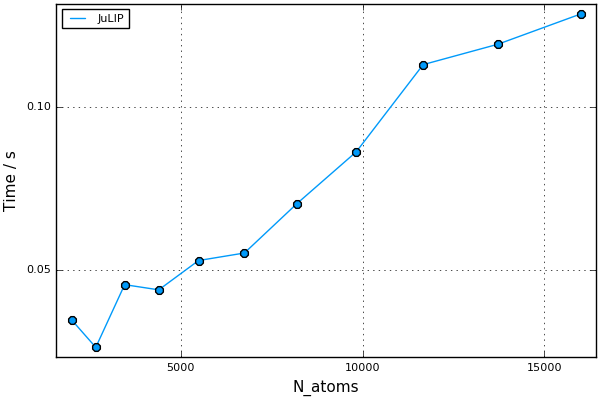

In [11]:
Nsup = 10:20
Natoms = 2*Nsup.^3
t_J = []
t_Q = []
for N = Nsup
    push!(t_J, @elapsed forces(sw_calc_J, at * (N, N, N)))
    #push!(t_Q, @elapsed forces(sw_calc_Q, at * (N, N, N)))
end

plot(Natoms, [t_J], label=[:JuLIP :QUIP], marker=:o, 
    xlabel="N_atoms", ylabel="Time / s")

## Energy volume plot

In [5]:
E = Float64[]
V = Float64[]
P = linspace(-0.01, 0.01, 5)
for p in P
    at = Atoms("Si")
    set_calculator!(at, sw_calc_J)
    set_constraint!(at, VariableCell(at, pressure=p))
    minimise!(at, verbose=2)
    V1 = det(defm(at))
    @printf("p=%.3f, V1=%.3f\n", p, V1)
    push!(E, energy(at))
    push!(V, V1)
end

Iter     Function value   Gradient norm 
     0    -9.070254e+00     7.616156e-02
     1    -9.072939e+00     8.693099e-02
     2    -9.073023e+00     3.316843e-02
     3    -9.073013e+00     6.614800e-02
Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [-0.00021757926072457927,-0.00021757926072457927, ...]
 * Minimum: -9.073013e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-06: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 66
 * Gradient Calls: 63
p=-0.010, V1=40.585
Iter     Function value   Gradient norm 
     0    -8.870125e+00     3.930544e-02
     1    -8.870830e+00     4.851046e-02
     2    -8.870856e+00     1.693987e-02
     3    -8.870847e+00     4.193162e-02
Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [-7.231910005

## Quadratic fit

quadratic fit: V0=40.047, Bulk modulus K = 125.969 GPa


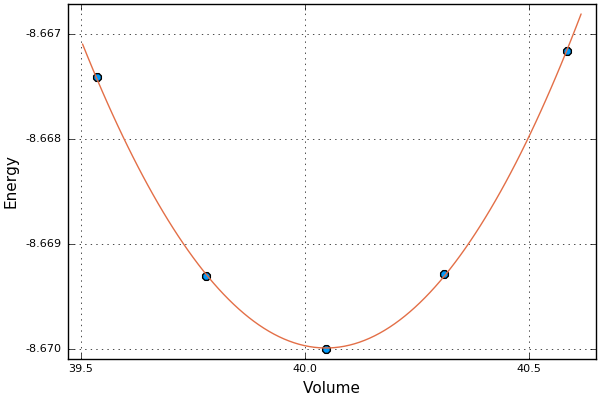

In [6]:
p = polyfit(V, E, 2)
V0, = roots(polyder(p))
K = -p[1]
@printf("quadratic fit: V0=%.3f, Bulk modulus K = %.3f GPa", V0, K/units.GPa)

scatter(V, E, marker=:o)
plot!(v -> polyval(p, v), xlabel=:Volume, ylabel=:Energy, legend=false)

## Linear fit

linear fit: V0=40.052 A^3, Bulk modulus K = 121.864 GPa


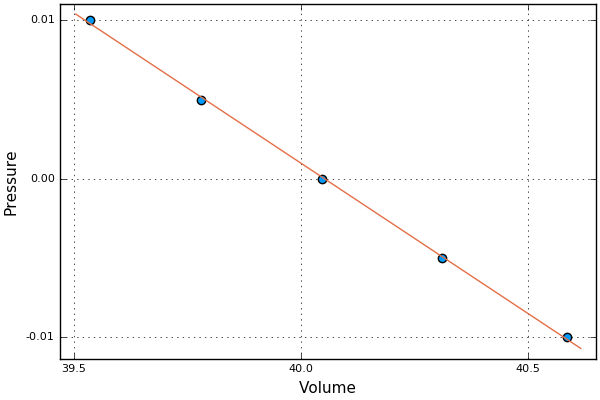

In [8]:
p = polyfit(V, collect(P), 1)
V0, = roots(p)
K = - V0 * polyval(polyder(p), V0)
@printf("linear fit: V0=%.3f A^3, Bulk modulus K = %.3f GPa", V0, K/units.GPa)

scatter(V, P)
plot!(x -> polyval(p, x), xlabel=:Volume, ylabel=:Pressure, legend=false)